In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import datetime
from sqlalchemy import create_engine
%matplotlib inline
import matplotlib.pyplot as plt

# READ IN DATA

In [2]:
engine = create_engine("sqlite:///mta_data.db")

In [3]:
df = pd.read_sql("SELECT * FROM mta_data WHERE DATE LIKE '%21'", engine)

In [4]:
df['DATE_TIME'] = pd.to_datetime(df['DATE'] + " " + df['TIME'], format = "%m/%d/%Y %H:%M:%S")
df['DATE'] = pd.to_datetime(df.DATE)

In [5]:
df.dtypes

C/A                  object
UNIT                 object
SCP                  object
STATION              object
LINENAME             object
DIVISION             object
DATE         datetime64[ns]
TIME                 object
DESC                 object
ENTRIES               int64
EXITS                 int64
DATE_TIME    datetime64[ns]
dtype: object

In [6]:
#Data for all of 2021.
df.DATE.value_counts().sort_index()

2021-01-01    30696
2021-01-02    30595
2021-01-03    29807
2021-01-04    29779
2021-01-05    29802
              ...  
2021-12-20    30120
2021-12-21    30015
2021-12-22    30005
2021-12-23    30232
2021-12-24    29969
Name: DATE, Length: 358, dtype: int64

In [7]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME'],
      dtype='object')

In [8]:
df.shape

(10717660, 12)

In [9]:
df.columns = [column.strip() for column in df.columns]
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'DATE_TIME'],
      dtype='object')

# CLEAN AND PREP DATA

In [10]:
# Make a copy and sort values descending date and time by turnstile
turnstiles_hourly = (df.copy()
                     .sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "DESC"], ascending=False))

### Deal with duplicate entries

In [11]:
# Checking for duplicate entries
(turnstiles_hourly
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 ['ENTRIES', 'EXITS'].count()
 .reset_index()
 .sort_values(["ENTRIES", "EXITS"], ascending=False)).head()

/var/folders/bh/c8vgcl4518l2jtlcnl312lt00000gn/T/ipykernel_85125/3135465926.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  (turnstiles_hourly


,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
892895,B022,R229,00-05-02,AVENUE M,2021-12-21 11:00:00,2,2
892896,B022,R229,00-05-02,AVENUE M,2021-12-21 15:00:00,2,2
912941,B024,R211,00-05-00,KINGS HWY,2021-05-01 00:00:00,2,2
912943,B024,R211,00-05-00,KINGS HWY,2021-05-01 08:00:00,2,2
912944,B024,R211,00-05-00,KINGS HWY,2021-05-01 12:00:00,2,2


In [12]:
# Looking at a duplicate entry 
mask = ((turnstiles_hourly["C/A"] == "N071") &
        (turnstiles_hourly["UNIT"] == "R013") & 
        (turnstiles_hourly["SCP"] == "00-06-00") & 
        (turnstiles_hourly["STATION"] == "34 ST-PENN STA") &
        (turnstiles_hourly["DATE"] == "2021-04-08"))
       
turnstiles_hourly[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
7815863,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,20:00:00,REGULAR,687099,585257,2021-04-08 20:00:00
7815862,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,16:00:00,REGULAR,687081,585200,2021-04-08 16:00:00
7815861,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,12:00:00,RECOVR AUD,687066,585151,2021-04-08 12:00:00
7815859,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,08:00:00,REGULAR,262161,0,2021-04-08 08:00:00
7815860,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,08:00:00,RECOVR AUD,687057,585089,2021-04-08 08:00:00
7815858,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,06:41:49,REGULAR,262161,0,2021-04-08 06:41:49
7815857,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,06:40:30,REGULAR,262161,0,2021-04-08 06:40:30
7815856,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,04:00:00,REGULAR,687051,585060,2021-04-08 04:00:00
7815855,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,00:00:00,REGULAR,687051,585059,2021-04-08 00:00:00


In [13]:
# check proportion of irregular reports
turnstiles_hourly[turnstiles_hourly.DESC != 'REGULAR'].shape[0]/turnstiles_hourly[turnstiles_hourly.DESC == 'REGULAR'].shape[0]

0.004248655657435963

Looking at the duplicate entry above, it looks like the RECOVR AUD line is inserted after a malfunction with the counter. So we'll want to keep the RECOVR AUD version and drop the duplicate REGULAR entry. 

In [14]:
turnstiles_hourly.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, keep = 'last')

In [15]:
# Checking that I dropped the REGULAR entry and kept the RECOVR AUD
turnstiles_hourly[mask]

/var/folders/bh/c8vgcl4518l2jtlcnl312lt00000gn/T/ipykernel_85125/2089095821.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  turnstiles_hourly[mask]


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
7815863,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,20:00:00,REGULAR,687099,585257,2021-04-08 20:00:00
7815862,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,16:00:00,REGULAR,687081,585200,2021-04-08 16:00:00
7815861,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,12:00:00,RECOVR AUD,687066,585151,2021-04-08 12:00:00
7815860,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,08:00:00,RECOVR AUD,687057,585089,2021-04-08 08:00:00
7815858,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,06:41:49,REGULAR,262161,0,2021-04-08 06:41:49
7815857,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,06:40:30,REGULAR,262161,0,2021-04-08 06:40:30
7815856,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,04:00:00,REGULAR,687051,585060,2021-04-08 04:00:00
7815855,N071,R013,00-06-00,34 ST-PENN STA,ACE,IND,2021-04-08,00:00:00,REGULAR,687051,585059,2021-04-08 00:00:00


It also looks like when the TIME is not on the hour, it is because of a malfunction with the counter, so we'll likely want to get rid of those instances. Let's see how many times that happens and then drop those if it's a small subset of the data. 

In [16]:
turnstiles_hourly['SECONDS'] = turnstiles_hourly.DATE_TIME.dt.second
turnstiles_hourly[turnstiles_hourly.SECONDS != 0].shape[0] / turnstiles_hourly.shape[0]

0.06529001013028667

In [17]:
#Dropping irregular time instances
turnstiles_hourly = turnstiles_hourly[turnstiles_hourly.SECONDS == 0]

### Calculate entries, exits, and total traffic

In [18]:
# Creating columns to use for upcoming calclations
turnstiles_hourly[['PREV_DATE_TIME','PREV_ENTRIES', 'PREV_EXITS']] = (turnstiles_hourly
.groupby(["C/A", "UNIT", "SCP", "STATION"])['DATE_TIME', 'ENTRIES', 'EXITS'].shift(-1))
turnstiles_hourly.head(5)

/var/folders/bh/c8vgcl4518l2jtlcnl312lt00000gn/T/ipykernel_85125/1714784987.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_hourly[['PREV_DATE_TIME','PREV_ENTRIES', 'PREV_EXITS']] = (turnstiles_hourly


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,SECONDS,PREV_DATE_TIME,PREV_ENTRIES,PREV_EXITS
210382,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-12-24,20:00:00,REGULAR,5562,994,2021-12-24 20:00:00,0,2021-12-24 16:00:00,5562.0,994.0
210381,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-12-24,16:00:00,REGULAR,5562,994,2021-12-24 16:00:00,0,2021-12-24 12:00:00,5562.0,979.0
210380,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-12-24,12:00:00,REGULAR,5562,979,2021-12-24 12:00:00,0,2021-12-24 08:00:00,5562.0,979.0
210379,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-12-24,08:00:00,REGULAR,5562,979,2021-12-24 08:00:00,0,2021-12-24 04:00:00,5562.0,979.0
210378,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,2021-12-24,04:00:00,REGULAR,5562,979,2021-12-24 04:00:00,0,2021-12-24 00:00:00,5562.0,979.0


In [19]:
# Drop the rows for the earliest date_time in the df
turnstiles_hourly.dropna(subset=["PREV_DATE_TIME"], axis=0, inplace=True)

In [20]:
#Calculate hourly entries and exits
turnstiles_hourly['HOURLY_ENTRIES'] = turnstiles_hourly.ENTRIES - turnstiles_hourly.PREV_ENTRIES

turnstiles_hourly['HOURLY_EXITS'] = turnstiles_hourly.EXITS - turnstiles_hourly.PREV_EXITS

In [21]:
#Calculate total traffic as the sum of entries and exits
turnstiles_hourly['HOURLY_IN_OUT'] = turnstiles_hourly.HOURLY_ENTRIES + turnstiles_hourly.HOURLY_EXITS

### Dealing with negative values, zero values, and suspiciously large values

In [22]:
# Calculate percentage of zero values of HOURLY_IN_OUT
turnstiles_hourly[turnstiles_hourly.HOURLY_IN_OUT == 0].shape[0] /  turnstiles_hourly.shape[0]

0.1262611992999754

In [23]:
# Calculate percentage of negative values of HOURLY_IN_OUT
turnstiles_hourly[turnstiles_hourly.HOURLY_IN_OUT < 0].shape[0] /  turnstiles_hourly.shape[0]

0.008749708248179753

In [24]:
turnstiles_hourly['TURNSTILE_DAILY_IN_OUT'] = (turnstiles_hourly.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])
              .HOURLY_IN_OUT.transform(lambda x: x.sum()))

In [25]:
#Let's see how many instances there are where the traffic for the day was 0,
#which would suggest the turnstile was closed or not working for the day
turnstiles_hourly[turnstiles_hourly.TURNSTILE_DAILY_IN_OUT == 0].shape[0] / turnstiles_hourly.shape[0]

0.08788538580301936

Next, let's check instances that suspiciously large. Let's assume that about 2,500 people is the maximum that could pass through a turnstile in an hour (which would be about 40 people per minute). That means 60,000 is the max that could pass through a turnstile in a day. 10,000 would be the max that can pass through in the typicaly four hour reporting period. Let's see how many values we have in the dataset above this threshhold and then get rid of those instances. 

In [26]:
turnstiles_hourly[turnstiles_hourly.TURNSTILE_DAILY_IN_OUT > 60000].shape[0] / turnstiles_hourly.shape[0]

7.680176286511923e-05

In [27]:
#Get rid of instances where total entries for a day were <= 0, as the turnstile was likely down for the day
turnstiles_hourly = turnstiles_hourly[(turnstiles_hourly.TURNSTILE_DAILY_IN_OUT > 0) &
                                     (turnstiles_hourly.TURNSTILE_DAILY_IN_OUT <= 60000)]

In [28]:
turnstiles_hourly[turnstiles_hourly.HOURLY_IN_OUT <0].shape[0] / turnstiles_hourly.shape[0]

0.0006022015398821505

In [29]:
# Do similar for HOURLY_IN_OUT so we don't have negative values messing with our data 
# when aggregating across different time periods
turnstiles_hourly = turnstiles_hourly[(turnstiles_hourly.HOURLY_IN_OUT > 0) &
                                     (turnstiles_hourly.HOURLY_IN_OUT <= 10000)]

# VISUALIZE DATA

### Calculate daily entries for each station

In [30]:
#Calculate daily traffic by station
daily_in_out = (turnstiles_hourly.groupby(['STATION', 'DATE'])
                 .HOURLY_IN_OUT.sum()
                 .reset_index()
                 .rename(columns = {'HOURLY_IN_OUT':'DAILY_IN_OUT'}))

#Calculate mean daily traffic by station
mean_daily_in_out = (daily_in_out.groupby(['STATION'])
                      .DAILY_IN_OUT.mean()
                      .reset_index()
                      .sort_values('DAILY_IN_OUT', ascending = False)
                      .rename(columns = {'DAILY_IN_OUT':'MEAN_DAILY_IN_OUT'}))

In [31]:
#Make a list of the 10 stations with the highest mean daily traffic and we'll focus our visualizations on those
top_10 = mean_daily_in_out.STATION.unique()[:10]
top_10

array(['34 ST-PENN STA', '34 ST-HERALD SQ', 'GRD CNTRL-42 ST', '86 ST',
       '14 ST-UNION SQ', '23 ST', '125 ST', '42 ST-PORT AUTH',
       'TIMES SQ-42 ST', 'FULTON ST'], dtype=object)

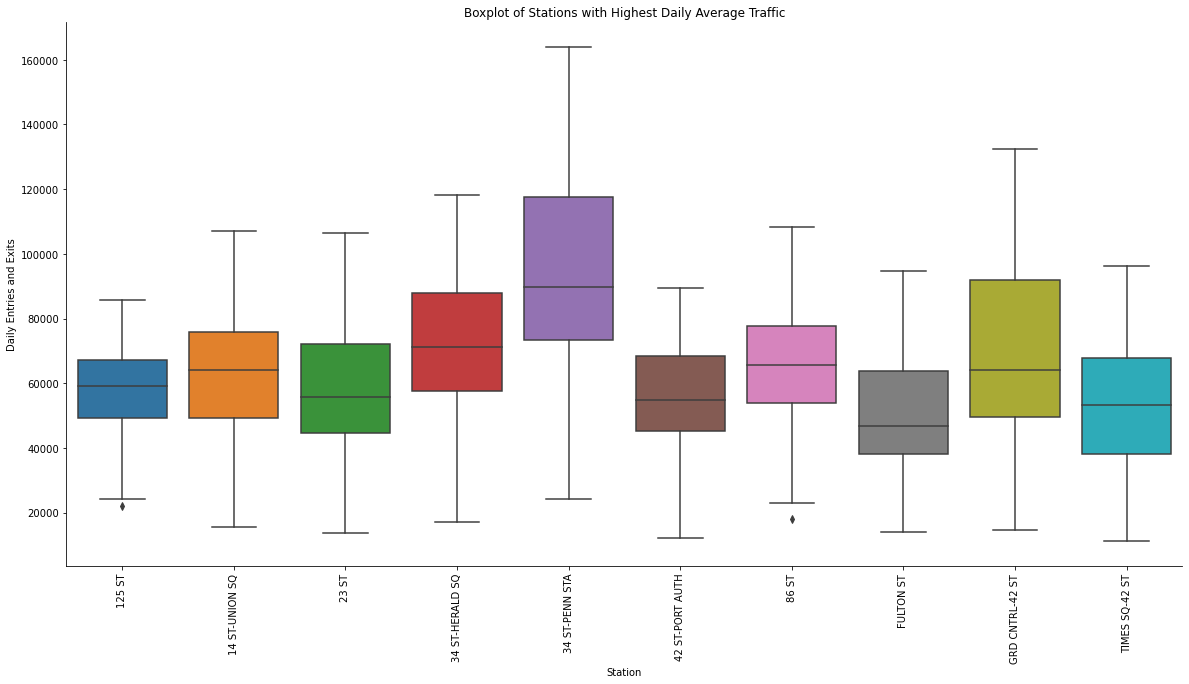

In [32]:
box_plot_fig = plt.figure()
box_plot_fig.set_figheight(10)
box_plot_fig.set_figwidth(20)
sns.boxplot(x = 'STATION', y = 'DAILY_IN_OUT', data = daily_in_out[daily_in_out.STATION.isin(top_10)])
plt.title('Boxplot of Stations with Highest Daily Average Traffic')
plt.ylabel('Daily Entries and Exits')
plt.xlabel('Station')
plt.xticks(rotation = 90)
sns.despine()
plt.savefig('stations_boxplot.jpg', bbox_inches = 'tight');

<Figure size 432x288 with 0 Axes>

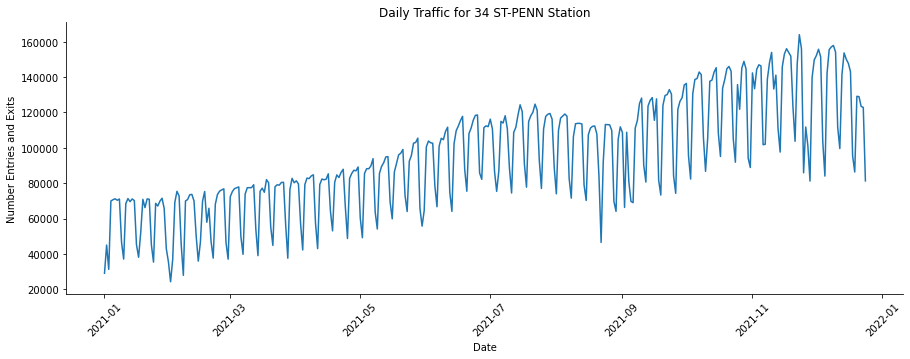

In [33]:
#Let's take the busiest station and look at daily traffic throughout the year
penn_daily_av = daily_in_out[daily_in_out['STATION'] == '34 ST-PENN STA']

penn_avg_fig = plt.figure()
plt.figure(figsize=(15,5))
plt.plot(penn_daily_av['DATE'], penn_daily_av['DAILY_IN_OUT'])
plt.ylabel('Number Entries and Exits')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title('Daily Traffic for 34 ST-PENN Station')
sns.despine()
plt.savefig('penn_daily.jpg');

In [34]:
#Now lets look at traffic throughout the year for the 10 busiest stations
daily_in_out['MONTH'] = daily_in_out['DATE'].dt.month

monthly_in_out = daily_in_out[daily_in_out.STATION.isin(top_10)]
monthly_in_out = (monthly_in_out.groupby(['STATION','MONTH'])
                  .DAILY_IN_OUT.sum()
                  .reset_index()
                  .rename(columns = {'DAILY_IN_OUT':'MONTHLY_IN_OUT'})
                 )

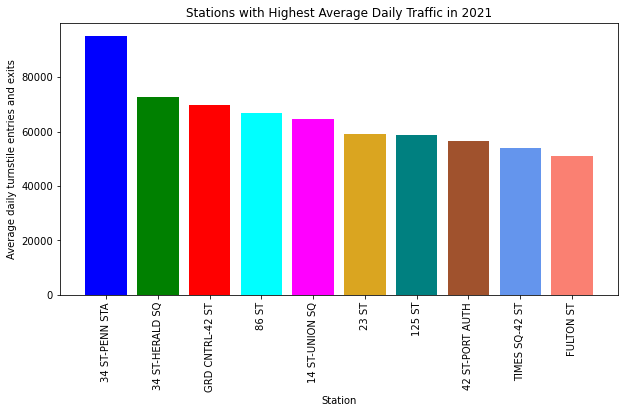

In [35]:
plt.figure(figsize=(10,5))
plt.bar(x = mean_daily_in_out.STATION[:10], height = mean_daily_in_out.MEAN_DAILY_IN_OUT[:10], 
        color = ['blue','green','red','cyan','magenta','goldenrod','teal','sienna','cornflowerblue','salmon'])
plt.xticks(rotation=90)
plt.xlabel('Station')
plt.ylabel('Average daily turnstile entries and exits')
plt.title('Stations with Highest Average Daily Traffic in 2021')
plt.savefig('top_10.jpg', bbox_inches = 'tight');

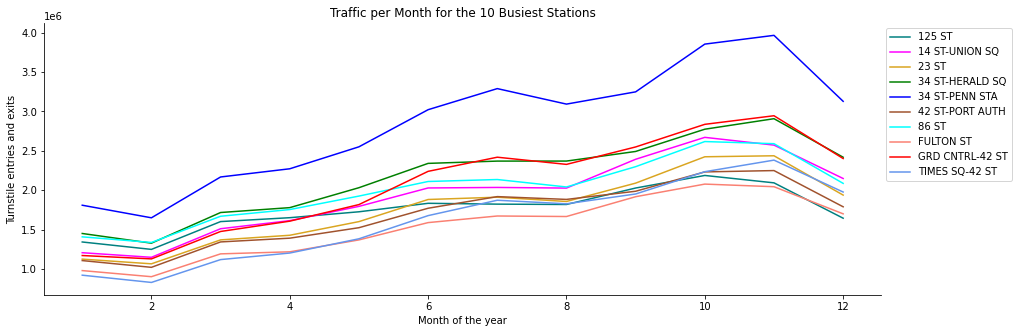

In [36]:
colors = {'34 ST-PENN STA':'blue','34 ST-HERALD SQ':'green',
          'GRD CNTRL-42 ST':'red','86 ST':'cyan','14 ST-UNION SQ':'magenta','23 ST':'goldenrod',
          '125 ST':'teal','42 ST-PORT AUTH':'sienna','TIMES SQ-42 ST':'cornflowerblue',
          'FULTON ST':'salmon'}

plt.figure(figsize=(15,5))
for name, group in monthly_in_out.groupby('STATION'):
    plt.plot(group['MONTH'], group['MONTHLY_IN_OUT'], color = colors[name], label = name)

plt.xlabel('Month of the year')
plt.ylabel('Turnstile entries and exits')
plt.title('Traffic per Month for the 10 Busiest Stations')
sns.despine()
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('stations_monthly.jpg', bbox_inches = 'tight');

In [37]:
#Let's check out how traffic changes throughout the day at the busiest station
stations_hourly = (turnstiles_hourly[turnstiles_hourly.STATION.isin(top_10)]
               .groupby(['STATION','TIME']).HOURLY_IN_OUT.mean().reset_index()
               .sort_values(['STATION', 'TIME']))
stations_hourly['TIME'] = pd.to_timedelta(stations_hourly['TIME'])
stations_hourly = (stations_hourly
                   .groupby('STATION')
                   .resample('4H', on='TIME').sum()
                   .reset_index())

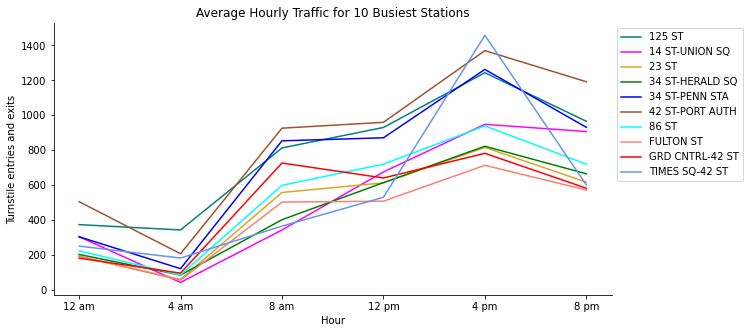

In [38]:
ticks = stations_hourly.TIME.unique().astype('object')
labels = ['12 am','4 am','8 am','12 pm','4 pm','8 pm']

plt.figure(figsize=(10,5))
for name, group in stations_hourly.groupby('STATION'):
    plt.plot(group['TIME'], group['HOURLY_IN_OUT'], color = colors[name], label=name)

plt.ylabel('Turnstile entries and exits')
plt.xlabel('Hour')
plt.xticks(ticks = ticks, labels = labels)
plt.title('Average Hourly Traffic for 10 Busiest Stations')
sns.despine()
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('stations_hourly.jpg', bbox_inches = 'tight');

In [39]:
#Let's zoom in on hourly traffic at the busiest station, 34 ST-PENN STA
penn_hourly = (turnstiles_hourly[turnstiles_hourly.STATION == '34 ST-PENN STA']
               .groupby(['STATION','TIME']).HOURLY_IN_OUT.mean().reset_index()
               .sort_values(['STATION', 'TIME']))

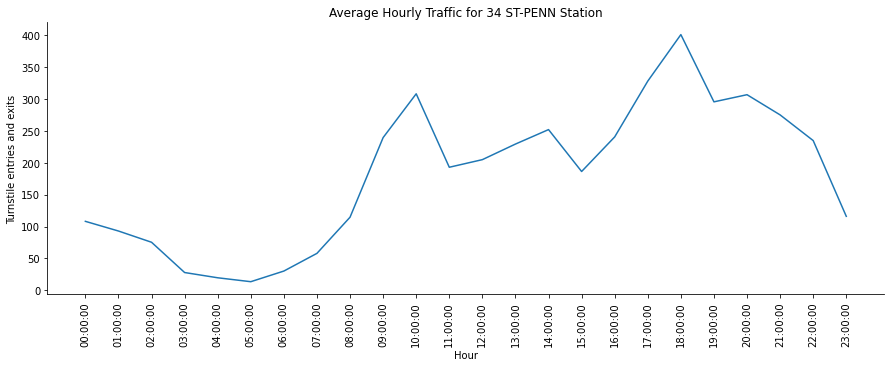

In [40]:
plt.figure(figsize=(15,5))
plt.plot(penn_hourly['TIME'], penn_hourly['HOURLY_IN_OUT'])
plt.ylabel('Turnstile entries and exits')
plt.xlabel('Hour')
plt.xticks(rotation = 90)
plt.title('Average Hourly Traffic for 34 ST-PENN Station')
sns.despine()
plt.savefig('penn_hourly.jpg', bbox_inches = 'tight');

In [41]:
#Lastly, let's look at how mean traffic differs on each day of the week
daily_in_out['DOW'] = daily_in_out.DATE.dt.weekday
week_avg = (daily_in_out[daily_in_out.STATION.isin(top_10)]
            .groupby(['STATION', 'DOW'])
            .DAILY_IN_OUT.mean()
            .reset_index()
            .sort_values(['STATION', 'DOW']))

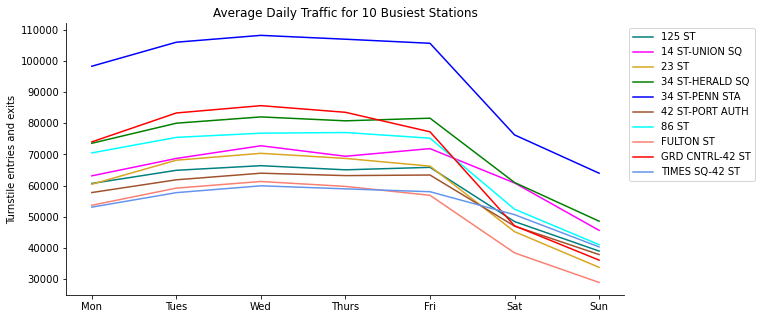

In [42]:
ticks = range(0,7,1)
labels = ['Mon', 'Tues','Wed','Thurs','Fri','Sat','Sun']

plt.figure(figsize=(10,5))
for name, group in week_avg.groupby('STATION'):
    plt.plot(group['DOW'], group['DAILY_IN_OUT'], color = colors[name], label = name)

plt.ylabel('Turnstile entries and exits')
plt.xticks(ticks = ticks, labels = labels)
plt.title('Average Daily Traffic for 10 Busiest Stations')
sns.despine()
plt.legend(bbox_to_anchor=(1, 1))
plt.savefig('stations_weekly.jpg', bbox_inches = 'tight');